In [3]:
import cv2
import easyocr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import re



In [15]:

# def extract_frame(video_path, frame_number=0):
#     # Open the video file
#     cap = cv2.VideoCapture(video_path)
    
#     # Check if video opened successfully
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return
    
#     # Get video properties
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = cap.get(cv2.CAP_PROP_FPS)
    
#     # print(f"Total frames: {total_frames}")
#     # print(f"FPS: {fps}")
    
#     # Set frame position
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
#     # Read frame
#     ret, frame = cap.read()
    
#     if not ret or frame is None:
#         print("Error: Could not read frame.")
#         return None, total_frames, fps
    
#     # Release video capture object
#     cap.release()

#     return frame, total_frames, fps

# ...existing code...
import math
from tqdm.auto import tqdm

def extract_frame(video_path, frame_number=0):
    # Try multiple OpenCV backends
    cap = None
    for backend in (cv2.CAP_ANY, cv2.CAP_FFMPEG, cv2.CAP_GSTREAMER):
        try:
            cap = cv2.VideoCapture(video_path) if backend == cv2.CAP_ANY else cv2.VideoCapture(video_path, backend)
            if cap.isOpened():
                break
            cap.release()
            cap = None
        except Exception:
            cap = None

    if cap is None or not cap.isOpened():
        tqdm.write(f"[WARN] Could not open video: {video_path}")
        return None, None, None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    try:
        if math.isnan(fps):
            fps = 0.0
    except Exception:
        pass

    # Clamp requested frame into range
    if total_frames > 0 and frame_number >= total_frames:
        frame_number = max(0, total_frames - 1)

    if frame_number > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()

    if not ret or frame is None:
        # Fallback: read first frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()

    cap.release()

    if not ret or frame is None:
        tqdm.write(f"[WARN] Could not read a frame from: {video_path}")
        return None, (total_frames or None), (fps or None)

    return frame, total_frames, fps
# ...existing code...
# Usage examples
video_path = '/cosma7/data/dp004/rrtx34/ultrasound/JCUH/001/JCUH001_LUS_4/20230517_191956_0003.AVI'

# Extract single frame (frame 10)
frame, total_frames, fps = extract_frame(video_path, 10)


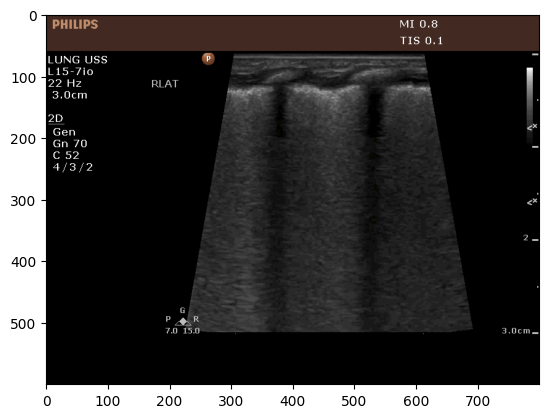

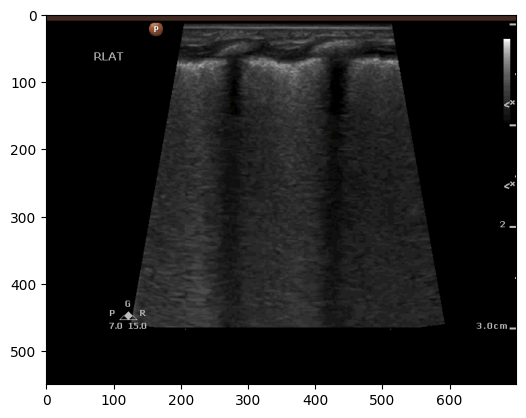

In [16]:

plt.imshow(frame)
plt.show()

# frame_cut = frame[110:280,:300]
# plt.imshow(frame_cut)

scan_label_cut = frame[50:, 100:]
plt.imshow(scan_label_cut)

/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[('RLAT', np.float64(0.9997323155403137)),
 ('ZR', np.float64(0.22488578742429213)),
 ('70', np.float64(0.9998964889092362)),
 ('1520', np.float64(0.6092913150787354)),
 ('3Ocmg', np.float64(0.29389204981098194))]

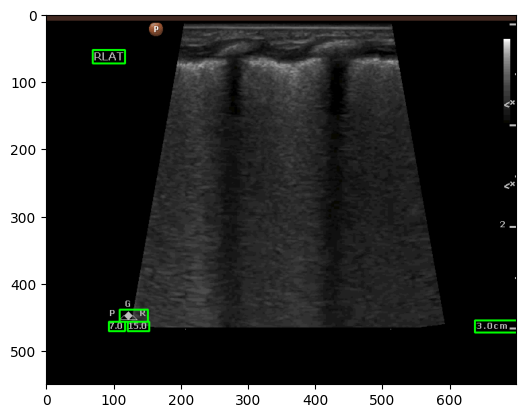

In [17]:
import easyocr
import cv2
import numpy as np

def read_text(image_path, min_confidence=0.0, reader=None):
    # Initialize reader for English only
    if reader is None:
        reader = easyocr.Reader(['en'], gpu=True, verbose=False)

    if not isinstance(image_path, np.ndarray):
        # Read image

        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Perform OCR - lowered text_threshold to catch more detections
    results = reader.readtext(
        image,
        detail=1,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789/',
        text_threshold=0.1,  # Lower threshold to catch more text
        paragraph=False
    )
    
    # Draw results on image and print text
    detected_texts = []
    for (bbox, detected_text, prob) in results:
        # Only include results above minimum confidence
        if prob < min_confidence:
            continue
            
        # Get corner points
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
    #     # Draw rectangle and text
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    #     cv2.putText(image, detected_text, (top_left[0], top_left[1] - 10),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
        detected_texts.append((detected_text, prob))
        # print(f"Text: {detected_text} (Confidence: {prob:.2f})")
    
    # Display result
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(image)
    return detected_texts

# Usage
image_path = scan_label_cut
read_text(image_path, min_confidence=0.0)  # Set to 0.0 to see all detections

In [18]:
# get scan label from detected texts
# detected_texts = read_text(image_path, min_confidence=0.0)
# scan_label = None
possibilities = ['RUA', 'RLA', 'RLAT', 'RUP', 'RLP', 'LUA', 'LLA', 'LLP', 'LUP', 'LLP', 'RAA', 'RAB', 'RLT', 'RPA', 'RPB', 'LAA', 'LAB', 'LLAT', 'LLT', 'LPA', 'LPB', 'RLATERAL', 'RAX', 'LLATERAL', 'LAX']

def find_scan_label(detected_texts, possibilities):
    for text, prob in detected_texts:
        if text in possibilities:
            if prob >= 0.5:  # confidence threshold
                return text
    return None



Directory exists: True -> /cosma7/data/dp004/rrtx34/ultrasound/JCUH
Sample entries: ['034', '024', '011', '018', '021']


Indexing videos in JCUH: 0it [00:00, ?it/s]

Indexing videos in 034: 0it [00:00, ?it/s]

Indexing videos in JCUH_034_LUS_2_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_034_LUS_1_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_034_LUS_4_Supine:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_034_LUS_3_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 024: 0it [00:00, ?it/s]

Indexing videos in JCUH_024_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_024_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_024_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_024_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in 011: 0it [00:00, ?it/s]

Indexing videos in JCUH_011_LUS_1_Extra_12:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_011_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_011_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_011_LUS_2_StillImage: 0it [00:00, ?it/s]

Indexing videos in 018: 0it [00:00, ?it/s]

Indexing videos in JCUH_018_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_018_LUS_2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_018_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_018_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 021: 0it [00:00, ?it/s]

Indexing videos in JCUH_021_LUS_2:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_021_LUS_1:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_021_LUS_3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_021_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in 027: 0it [00:00, ?it/s]

Indexing videos in JCUH_027_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_027_LUS_3:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in JCUH_027_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_027_LUS_1:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in 026: 0it [00:00, ?it/s]

Indexing videos in JCUH_026_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_026_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_026_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_026_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 015: 0it [00:00, ?it/s]

Indexing videos in JCUH_015_LUS_4:   0%|          | 0/9 [00:00<?, ?it/s]

Indexing videos in JCUH_015_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_015_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_015_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 037: 0it [00:00, ?it/s]

Indexing videos in JCUH_037_LUS_3_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_037_LUS_1_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 038: 0it [00:00, ?it/s]

Indexing videos in JCUH_038_LUS_2_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_038_LUS_1_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_038_LUS_3_Lt side down_lateral:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_038_LUS_4_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 025: 0it [00:00, ?it/s]

Indexing videos in JCUH_025_LUS_4:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in JCUH_025_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_025_LUS_3:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in JCUH_025_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH 029: 0it [00:00, ?it/s]

Indexing videos in JCUH_029_LUS_1_supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_029_LUS_2_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_029_LUS_3_Prone:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in 002: 0it [00:00, ?it/s]

Indexing videos in JCUH002_LUS_1:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH002_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH002_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH002_LUS_3:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in 017: 0it [00:00, ?it/s]

Indexing videos in JCUH_017_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_017_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_017_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_017_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 004: 0it [00:00, ?it/s]

Indexing videos in JCUH004_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH004_LUS_4:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in JCUH004_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH004_LUS_1:   0%|          | 0/19 [00:00<?, ?it/s]

Indexing videos in 023: 0it [00:00, ?it/s]

Indexing videos in JCUH_023_LUS_1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_023_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_023_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_023_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in 009: 0it [00:00, ?it/s]

Indexing videos in JCUH009_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH009_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 008: 0it [00:00, ?it/s]

Indexing videos in JCUH008_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH008_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH008_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH008_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 007: 0it [00:00, ?it/s]

Indexing videos in JCUH007_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH007_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH007_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH007_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 005: 0it [00:00, ?it/s]

Indexing videos in JCUH005_LUS_2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH005_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH005_LUS_3:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in JCUH005_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in 001: 0it [00:00, ?it/s]

Indexing videos in JCUH001_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH001_LUS_3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH001_LUS_1:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in JCUH001_LUS_2:   0%|          | 0/17 [00:00<?, ?it/s]

Indexing videos in 013: 0it [00:00, ?it/s]

Indexing videos in JCUH_013_LUS_4:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH_013_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_013_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_013_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 020: 0it [00:00, ?it/s]

Indexing videos in JCUH_020_LUS_4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH_020_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_020_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_020_LUS_1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in 035: 0it [00:00, ?it/s]

Indexing videos in JCUH_035_LUS_1_supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_035_LUS_3_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 003: 0it [00:00, ?it/s]

Indexing videos in JCUH003_LUS_4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in JCUH003_LUS_3:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH003_LUS_1:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in JCUH003_LUS_2:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in 032: 0it [00:00, ?it/s]

Indexing videos in JCUH_032_LUS_2_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_032_LUS_4_prone:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in JCUH_032_LUS_1_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_032_LUS_3_Prone:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in 028: 0it [00:00, ?it/s]

Indexing videos in JCUH_028_LUS_2: 0it [00:00, ?it/s]

Indexing videos in JCUH_028_LUS_4:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH_028_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_028_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 031: 0it [00:00, ?it/s]

Indexing videos in JCUH_031_LUS_1_Supine:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_031_LUS_2_Supine:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_031_LUS_4_Prone:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in JCUH_031_LUS_3_Supine:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in 014: 0it [00:00, ?it/s]

Indexing videos in JCUH_014_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH_014_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_014_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_014_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 016: 0it [00:00, ?it/s]

Indexing videos in JCUH_016_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_016_LUS_4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_016_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_016_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 012: 0it [00:00, ?it/s]

Indexing videos in JCUH_012_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_012_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_012_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_012_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 036: 0it [00:00, ?it/s]

Indexing videos in JCUH_036_LUS_1_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_036_LUS_4_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_036_LUS_2_Supine:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in 033: 0it [00:00, ?it/s]

Indexing videos in JCUH_033_LUS_1_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_033_LUS_2_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_033_LUS_4_Supine:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in JCUH_033_LUS_3_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 006: 0it [00:00, ?it/s]

Indexing videos in JCUH006_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH006_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH006_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH006_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH 030: 0it [00:00, ?it/s]

Indexing videos in JCUH_030_LUS_1_supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_030_LUS_2_Prone:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_030_LUS_3_Supine:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_030_LUS_4_Supine:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in 022: 0it [00:00, ?it/s]

Indexing videos in JCUH_022_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_022_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_022_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_022_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in 019: 0it [00:00, ?it/s]

Indexing videos in JCUH_019_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_019_LUS_3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in JCUH_019_LUS_2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_019_LUS_4:   0%|          | 0/18 [00:00<?, ?it/s]

Indexing videos in 010: 0it [00:00, ?it/s]

Indexing videos in JCUH_010_LUS_2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in JCUH_010_LUS_3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_010_LUS_1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in JCUH_010_LUS_4:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting scan labels (OCR):   0%|          | 0/1595 [00:00<?, ?it/s]

[WARN] Could not open video: /cosma7/data/dp004/rrtx34/ultrasound/JCUH/010/JCUH_010_LUS_1/20230914_094225_0004.AVI


[ WARN:0@2417.941] global cap.cpp:215 open VIDEOIO(FFMPEG): backend is generally available but can't be used to capture by name


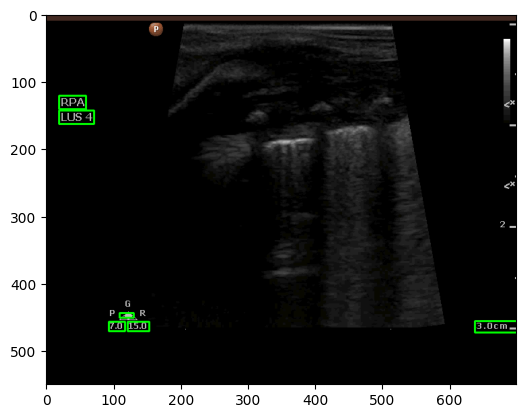

In [19]:


# Set the directory path
dir_path = r'/cosma7/data/dp004/rrtx34/ultrasound/JCUH'

# Diagnostics
print(f"Directory exists: {os.path.exists(dir_path)} -> {dir_path}")
if os.path.exists(dir_path):
    try:
        print("Sample entries:", os.listdir(dir_path)[:5])
    except Exception as e:
        print("Could not list directory contents:", e)

# Create an empty list to store the file names and paths
file_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    files = [ fi for fi in files if fi.endswith(".AVI") or fi.endswith(".MP4") ]
    for file in tqdm(files, desc=f"Indexing videos in {os.path.basename(root)}", leave=False):
        # Get the file path
        file_path = os.path.join(root, file)
        scan_filename = os.path.split(os.path.dirname(file_path))[-1]
        re_match = re.search(r'LUS_[1-4]', scan_filename)
        scan_no = re_match.group(0)
        patient_id_filename = os.path.split(os.path.dirname(os.path.dirname(file_path)))[-1]
        re_match_1 = re.search(r'[0-9][0-9][0-9]', patient_id_filename)
        patient_id = re_match_1.group(0) 
        # Append the file name and path to the list
        file_list.append({'Hospital': 'JCUH', 'File Path': file_path, 'Patient ID': patient_id, 'Scan No': scan_no})

ocr_reader = easyocr.Reader(['en'], gpu=True, verbose=False)
# add scan label column
for file_info in tqdm(file_list, desc="Extracting scan labels (OCR)"):
    video_path = file_info['File Path']
    frame, total_frames, fps = extract_frame(video_path, frame_number=10)

    file_info['Total Frames'] = total_frames or 0
    file_info['FPS'] = fps or 0.0

    if frame is None:
        file_info['Scan Label'] = 'Unknown'
        file_info['Read Error'] = True
        continue

    h, w = frame.shape[:2]
    y0, x0 = 50, 100
    scan_label_cut = frame[min(y0, h):h, min(x0, w):w]

    detected_texts = read_text(scan_label_cut, min_confidence=0.0, reader=ocr_reader)
    scan_label = find_scan_label(detected_texts, possibilities)
    file_info['Scan Label'] = scan_label if scan_label else 'Unknown'

    if file_info['Scan No'] == 'LUS_4':
        file_info['Scan No'] = 'LU_4'


# Create a Pandas DataFrame from the list
df_path = pd.DataFrame(file_list)

In [20]:
# Change scan label to expert scan label
def to_expert_label(label: str) -> str:
    s = str(label).upper()
    if s in ("RLAT", "RLATERAL", "RAX", "RLT"):
        return "Rax"
    if s == "RUA":
        return "RAA"
    if s == "RLA":
        return "RAB"
    if s == "RUP":
        return "RPA"
    if s == "RLP":
        return "RPB"
    if s == "LUA":
        return "LAA"
    if s == "LLA":
        return "LAB"
    if s in ("LLAT", "LLATERAL", "LAX", "LLT"):
        return "LAX"
    if s == "LUP":
        return "LPA"
    if s == "LLP":
        return "LPB"
    return label

df_path["Scan Label"] = df_path["Scan Label"].apply(to_expert_label)

In [21]:
# Add score
scores_directory = '/cosma7/data/dp004/rrtx34/ultrasound/Virginie_scores/Scores_JCUH'

def add_scores(df, scores_directory):
    # find patient score file
    for i in tqdm(df.index, desc="Adding scores"):
        patient_id = df.at[i, 'Patient ID']
        scan_no = df.at[i, 'Scan No']
        scan_label = df.at[i, 'Scan Label']

        df_score = None
        for file in os.listdir(scores_directory):
            if file.endswith(f"{patient_id}.xlsx"):
                df_score = pd.ExcelFile(os.path.join(scores_directory, file))
                sheets = df_score.sheet_names
                df_score = pd.read_excel(df_score, sheet_name=sheets[-1])
                break
        if df_score is None:
            continue
        # clean score data frames to remove empty rows and columns
        for col in df_score.columns:
            if df_score[col].isnull().all():
                df_score = df_score.drop(columns=[col])

        for index, row in df_score.iterrows():
            if row.isnull().all():
                df_score = df_score.drop(index=index)

        # make first row and column header
        df_score.columns = df_score.iloc[0]
        df_score = df_score[1:]
        df_score = df_score.set_index(df_score.columns[0])

        # add score to main dataframe
        if scan_label in df_score.index and scan_no in df_score.columns:
            score = df_score.at[scan_label, scan_no]
            df.at[i, 'Score'] = score

    return df
        
df_path = add_scores(df_path, scores_directory)
                

Adding scores:   0%|          | 0/1595 [00:00<?, ?it/s]

/tmp/ipykernel_520/1884162102.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ni' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Score'] = score


In [ ]:
# Save DataFrame to CSV
# df_path.to_csv('LUS_data.csv')

In [5]:
#  Print rows with unknown scan labels from LUS_data.csv
df_loaded = pd.read_csv('LUS_data.csv')
unknown_scan_labels = df_loaded[df_loaded['Scan Label'] == 'Unknown']

# make new csv with unknown scan labels
unknown_scan_labels.to_csv('LUS_data_unknown_scan_labels.csv', index=False)



In [5]:
# Find duplicate scan labels for each patient ID and scan no from csv
df_loaded = pd.read_csv('LUS_data.csv')
duplicates = df_loaded[df_loaded.duplicated(subset=['Patient ID', 'Scan No', 'Scan Label'], keep=False)]
duplicates.to_csv('LUS_data_duplicate_scan_labels.csv', index=False)